<a href="https://colab.research.google.com/github/CodeManJay/Movielens-Embedding-Recommendation-System/blob/main/Recommender_System_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System with Visualized Embeddings

The aim is to build a Movie Recommender System that can generate User and item Embeddings, and provide Recommendations based on it, while having the feature to visualize these Embeddings. Visualization of large chunks ofdata is necessary to analyse and verify them properly.  The movielens-100k dataset is chosen as the dataset for this project.  The aim is to utilize a novel combination of approaches for recommendations and visualization pertaining to this dataset.



# Explanation 1 by Vishvesh Pathak (AM.EN.U4CSE17354)

# Import all the necessary or Important libraries for this project.





In [54]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

In [55]:
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error 
from sklearn.neighbors import NearestNeighbors  
from sklearn.model_selection import StratifiedKFold

In [56]:
from keras.models import Model
%matplotlib inline

In [57]:
from urllib.request import urlretrieve
import collections
import zipfile

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams



# Retrieve dataset and URL, extract

In [59]:
print("Downloading dataset...")
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print(zip_ref.read('ml-100k/u.info'))

b'943 users\n1682 items\n100000 ratings\n'


# Analyse Dataset.

In [60]:
info = pd.read_csv("/content/ml-100k/u.info", sep=" ", header=None)
info.columns=['Counts', 'Type']
info

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [61]:
genre = pd.read_csv('/content/ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

# Remove delimiters,etc

In [62]:
item = pd.read_csv('/content/ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [63]:
data = pd.read_csv('/content/ml-100k/u.data', sep="\t", header=None)

In [64]:
data.columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
data.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [65]:
#Load the User data
user = pd.read_csv('/content/ml-100k/u.user', sep="|", encoding='latin-1', header=None)

In [66]:
user.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
user.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Specify the columns for users and ratings

In [67]:
# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

In [68]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

In [69]:
#different genre columns
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
#different movie columns, with genres appended
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols

movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [70]:
movies.columns

Index(['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'genre_unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [71]:
# ids must start from index 0, split release date, change ratings to float, etc
users["user_id"]=users["user_id"].apply(lambda x: int(x-1))

In [72]:
ratings["user_id"]=ratings["user_id"].apply(lambda x: int(x-1))
ratings["movie_id"]=ratings["movie_id"].apply(lambda x: int(x-1))
ratings["rating"]=ratings["rating"].apply(lambda x: float(x))

In [73]:
movies["movie_id"]=movies["movie_id"].apply(lambda x: int(x-1))
movies["year"]=movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Merge all these columns  for one final dataframe


In [74]:
movielens=ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [75]:
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1997,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1997,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1996,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1994,49,M,writer,55105


In [76]:
movielens.columns

Index(['user_id', 'movie_id', 'rating', 'unix_timestamp', 'title',
       'release_date', 'video_release_date', 'imdb_url', 'genre_unknown',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'year',
       'age', 'sex', 'occupation', 'zip_code'],
      dtype='object')

# Explanation 2 by Sreenivas Jayanth Yadhati (AM.EN.U4CSE17328)

# Split into training and test sets

In [77]:
train, test = train_test_split(movielens, test_size=0.1)

Number of rows

In [78]:
ROW_COUNT=train.shape[0]

In [79]:
#specifying embedding size, and assign all non unique user ids and movie ids
EMBEDDING_SIZE=10
NUM_USERS=movielens['user_id'].nunique()
NUM_MOVIES=movielens['movie_id'].nunique()

In [80]:
train.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,age,sex,occupation,zip_code
35657,362,216,2.0,891498286,Bram Stoker's Dracula (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Bram%20Stoker...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1992,20,M,student,87501
81815,346,194,4.0,881653603,"Terminator, The (1984)",01-Jan-1984,NaN,"http://us.imdb.com/M/title-exact?Terminator,%2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1984,18,M,student,90210
29685,787,809,3.0,880870773,"Shadow, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Shadow,%20The...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1994,51,M,administrator,05779
73507,127,415,3.0,879967367,Old Yeller (1957),01-Jan-1957,NaN,http://us.imdb.com/M/title-exact?Old%20Yeller%...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1957,24,F,marketing,20009
34298,421,123,3.0,875129839,Lone Star (1996),21-Jun-1996,NaN,http://us.imdb.com/M/title-exact?Lone%20Star%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1996,26,M,entertainment,94533


In [81]:
UNIQUE_MOVIE_IDS = movielens['movie_id'].unique()

# Create the Neural Network.

The dot product of the user embedding and item embedding vectors is taken.  Subsequently, the Neural Network Layers are created using the “Dense” func-tion  of  the  Keras  Library.The  dropout  function  is  implemented  to  reduceoverfitting.  The model is set for training for 50 epochs, and the “earlystop-ping”  parameter  is  set  for  stopping  the  training  if  validation  loss  doesn’tchange for 10 consecutive epochs .Other parameters are also finalized,  likethe Adam optimizer for Stochastic Gradient Descent

In [82]:
def EmbeddingNetwork(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input=keras.Input(shape=(1,), name='movie_id')
  # Add Embedding Layer for movies
    movie_embed_layer=layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_embedding_layer')(movie_input)
    movie_vector=layers.Flatten(name='FlattenMovie')(movie_embed_layer)
#Model Input for movies
    movie_model=keras.Model(inputs=movie_input, outputs=movie_vector)
    user_input=keras.Input(shape=(1,), name='user_id')
  #add embedding layer for user
    user_embed_layer=layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_embedding_layer')(user_input)
    user_vector=layers.Flatten(name='FlattenUser')(user_embed_layer)
  #Model input froM user
    user_model=keras.Model(inputs=user_input, outputs=user_vector)
  #Take the dot Product 
    merged=layers.Dot(name = 'dot_product_layer', normalize = True, axes = 2)([movie_embed_layer, user_embed_layer])
    merged_dropout=layers.Dropout(0.2)(merged)
    dense_1=layers.Dense(70,name='Layer_1')(merged)
    dropout_1=layers.Dropout(0.2,name='Dropout_1')(dense_1)
    dense_2=layers.Dense(50,name='Layer_2')(dropout_1)
    dropout_2=layers.Dropout(0.2,name='Dropout_2')(dense_2)
    dense_3=keras.layers.Dense(20,name='Layer_3')(dropout_2)
    dropout_3=keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)
    dense_4=keras.layers.Dense(10,name='Layer_4', activation='relu')(dropout_3)
    #output layer
    result=layers.Dense(1, name='result', activation="relu") (dense_4)
    adam=keras.optimizers.Adam(lr=0.001)
    model=keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error',metrics=["accuracy"])
    return model, movie_model, user_model

In [83]:
model, movie_model, user_model = EmbeddingNetwork(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [84]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movie_id, train.user_id],train.rating, batch_size=100,
                              epochs =50, validation_data = ([test.movie_id, test.user_id],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50
900/900 [==============================] - 3s 3ms/step - loss: 1.0577 - accuracy: 0.0602 - val_loss: 0.9508 - val_accuracy: 0.0623
Epoch 2/50
900/900 [==============================] - 2s 2ms/step - loss: 0.9490 - accuracy: 0.0610 - val_loss: 0.9308 - val_accuracy: 0.0623
Epoch 3/50
900/900 [==============================] - 2s 3ms/step - loss: 0.9306 - accuracy: 0.0610 - val_loss: 0.9193 - val_accuracy: 0.0623
Epoch 4/50
900/900 [==============================] - 2s 3ms/step - loss: 0.9176 - accuracy: 0.0610 - val_loss: 0.9161 - val_accuracy: 0.0623
Epoch 5/50
900/900 [==============================] - 2s 2ms/step - loss: 0.8790 - accuracy: 0.0610 - val_loss: 0.8255 - val_accuracy: 0.0623
Epoch 6/50
900/900 [==============================] - 2s 3ms/step - loss: 0.7484 - accuracy: 0.0610 - val_loss: 0.7763 - val_accuracy: 0.0623
Epoch 7/50
900/900 [==============================] - 2s 3ms/step - loss: 0.6923 - accuracy: 0.0610 - val_loss: 0.7628 - val_accuracy: 0.0623
Epoch 

# View the summary of the model

In [85]:
#print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding_layer (Embeddin (None, 1, 10)        16820       movie_id[0][0]                   
__________________________________________________________________________________________________
user_embedding_layer (Embedding (None, 1, 10)        9430        user_id[0][0]                    
____________________________________________________________________________________________

# Detailed model plot 

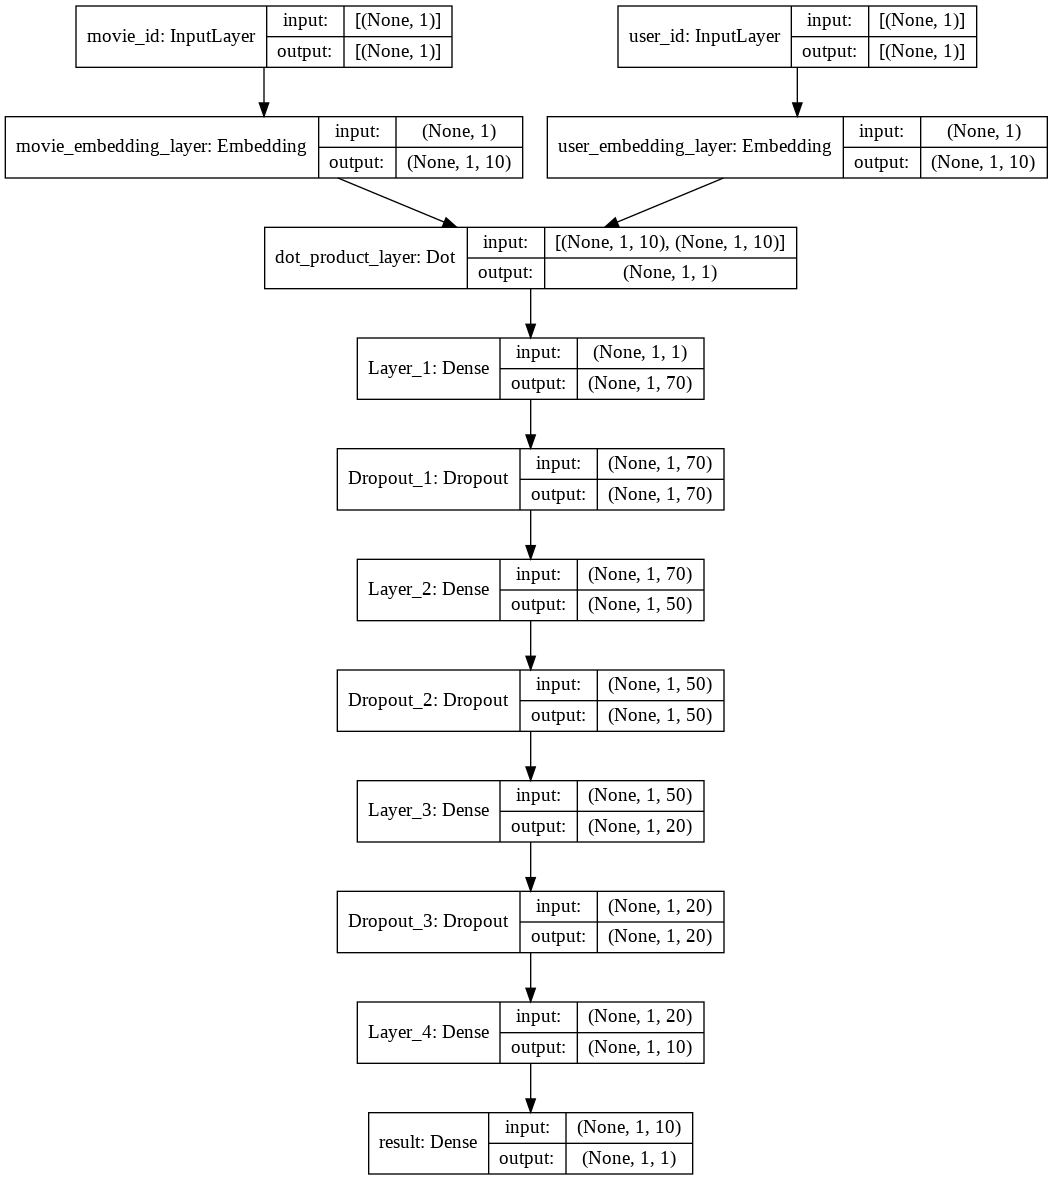

In [86]:
keras.utils.plot_model(model, show_shapes=True)

In [87]:
rcParams['figure.figsize'] = 10, 5

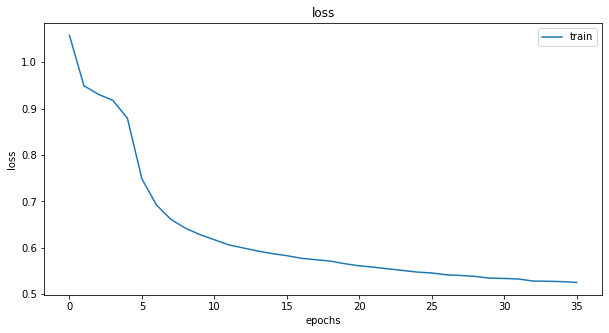

In [104]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.show()

# Explanation 3 by Vikyath S (AM.EN.U4CSE17261)

# t-SNE Implementation

Initialize an empty database and the embedding map.

In [89]:
MOVIE_EMBEDDINGS_DATABASE = []
EMBEDDING_MAP = collections.defaultdict()

for umovie_id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([umovie_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDINGS_DATABASE.insert(umovie_id, val)
    EMBEDDING_MAP[umovie_id] = val

It is important to visualize the movie data embeddings generated from movieID, in order to verify them.  For this, we shall use the T-Distributed Stochas-tic Neighbour EmbeddingTool.  Via this tool,  the higher dimensional datais reduced to two dimensions for proper visualization.  Along with this,theembeddings which are the most similar will be clustered together, while themore  dissimilar  embeddings  will  be  farther  in  distance.   The  “perplexity”parameter can be between 5 and50, and can be set accordingly.  40 is chosenas perplexity.

In [90]:
def plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDINGS_DATABASE[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
    plt.show()

## Plot TSNE Model

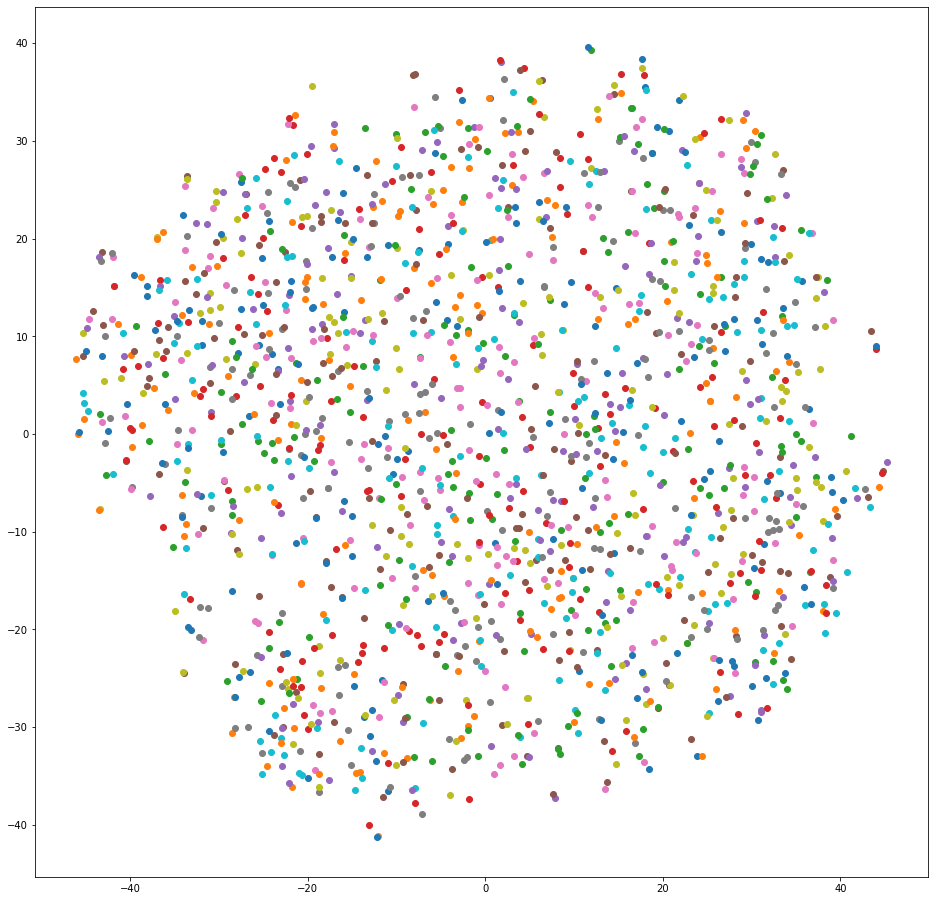

In [91]:
plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE)

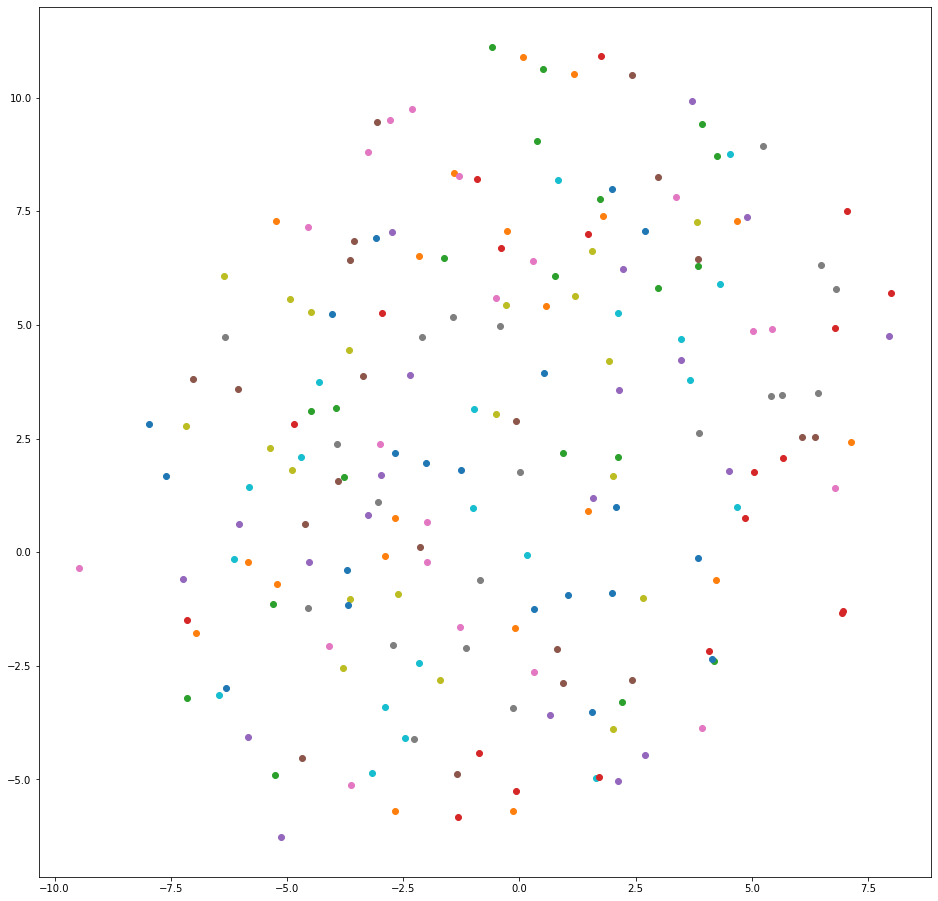

In [99]:
plot_tsne(model, MOVIE_EMBEDDINGS_DATABASE, 200)

# Explanation 4 by Vishnu Priya (AM.EN.U4CSE17241)

# KNN for closest neighbors

By passing the User ID, the user embeddings are generated.  These embeddings are used to look up the most similar movies.  Via the KNN approach,the closest embedded movies are shown as recommendation results

In [92]:
knn_train_ids = UNIQUE_MOVIE_IDS

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDINGS_DATABASE, knn_train_ids)

def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movie_id'])
    return df_indices.merge(movies,on='movie_id',how='inner',suffixes=['_u', '_m'])['title']

In [93]:
REC_USER_ID = 150

In [94]:
user_embedding=user_model.predict([REC_USER_ID]).reshape(1,-1)[0]

In [95]:
recommend_movies(user_embedding)

0    Winnie the Pooh and the Blustery Day (1968)
1                          On Golden Pond (1981)
2                             Chasing Amy (1997)
3                     Room with a View, A (1986)
4                    Beauty and the Beast (1991)
5                          Lion King, The (1994)
6                               Blob, The (1958)
7                        Frighteners, The (1996)
8                            Broken Arrow (1996)
9                              Unforgiven (1992)
Name: title, dtype: object

In [96]:
REC_USER_ID=355

In [97]:
user_embedding=user_model.predict([REC_USER_ID]).reshape(1,-1)[0]
recommend_movies(user_embedding)

0               Stranger, The (1994)
1                Men in Black (1997)
2            Crude Oasis, The (1995)
3          Warriors of Virtue (1997)
4       Dream With the Fishes (1997)
5    Ghost and Mrs. Muir, The (1947)
6               Fly Away Home (1996)
7                       Mondo (1996)
8                     Species (1995)
9                      Ransom (1996)
Name: title, dtype: object

In [101]:
model.save('my_model.h5')